In [49]:
import pandas as pd

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench201'

In [50]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [51]:
dataset = 'cifar10'
data = dfs[dataset]

In [80]:
import json
with open('meta.json', 'r') as f:
    meta = json.load(f)
nb201_unique = [v['nb201-string'] for k, v in meta['ids'].items() if k == v['isomorph']]
nb201_unique[0]

'|avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|'

In [84]:
from naslib.search_spaces.nasbench201.conversions import convert_str_to_op_indices

unique_nets = {str(convert_str_to_op_indices(nu)) for nu in nb201_unique}

{'(0, 0, 1, 0, 0, 4)',
 '(2, 3, 1, 0, 4, 1)',
 '(4, 0, 1, 4, 4, 3)',
 '(0, 0, 2, 4, 0, 3)',
 '(3, 1, 0, 2, 2, 0)',
 '(2, 4, 4, 3, 1, 0)',
 '(3, 2, 3, 3, 3, 4)',
 '(0, 3, 0, 3, 1, 4)',
 '(1, 0, 3, 3, 2, 3)',
 '(4, 4, 2, 2, 1, 3)',
 '(0, 2, 0, 4, 0, 3)',
 '(3, 2, 1, 0, 4, 4)',
 '(2, 3, 0, 3, 1, 3)',
 '(0, 2, 3, 0, 3, 0)',
 '(4, 3, 2, 1, 4, 0)',
 '(3, 4, 1, 3, 2, 2)',
 '(3, 2, 2, 0, 4, 4)',
 '(2, 2, 3, 4, 1, 3)',
 '(3, 0, 1, 4, 1, 2)',
 '(2, 4, 0, 1, 2, 3)',
 '(3, 2, 2, 3, 2, 3)',
 '(3, 3, 3, 1, 4, 0)',
 '(2, 3, 3, 0, 2, 2)',
 '(2, 4, 4, 3, 1, 2)',
 '(4, 1, 4, 4, 0, 3)',
 '(2, 4, 3, 4, 0, 4)',
 '(4, 0, 0, 3, 2, 3)',
 '(4, 3, 0, 3, 2, 4)',
 '(4, 2, 4, 3, 4, 0)',
 '(4, 3, 3, 4, 2, 0)',
 '(4, 2, 4, 0, 4, 4)',
 '(2, 3, 4, 1, 2, 3)',
 '(2, 4, 4, 4, 0, 3)',
 '(2, 0, 4, 2, 0, 0)',
 '(3, 2, 1, 1, 4, 2)',
 '(2, 3, 4, 2, 1, 4)',
 '(2, 4, 3, 4, 2, 3)',
 '(2, 2, 4, 1, 3, 0)',
 '(2, 0, 3, 2, 3, 4)',
 '(1, 3, 2, 3, 1, 0)',
 '(4, 3, 3, 3, 1, 3)',
 '(3, 4, 3, 0, 2, 0)',
 '(4, 1, 3, 4, 4, 3)',
 '(2, 4, 4,

In [86]:
data = data[data['net'].isin(unique_nets)]

In [87]:
from zc_combine.fixes.operations import get_ops_edges_nb201
from zc_combine.fixes.utils import nb201_default_isomorphic_cell

_, edge_map = get_ops_edges_nb201()
nb201_default_isomorphic_cell(data, edge_map)

In [88]:
print(len(data))
data = data[data['net'] == data['new_net']]
print(len(data))

6144
6144


In [92]:
from zc_combine.features.conversions import nb201_to_graph

nets = {i: nb201_to_graph(data.loc[i]) for i in data.index}

In [93]:
from zc_combine.features.counts import count_ops

op_counts = [{'idx': i, **count_ops(o, e)} for i, (o, e) in nets.items()]

In [94]:
import pandas as pd

opdf = pd.DataFrame(op_counts)
opdf.set_index('idx', inplace=True)
opdf['val_accs'] = data['val_accs']
opdf

,0,1,2,3,4,val_accs
idx,,,,,,
0,1,1,0,2,2,84.99
1,2,0,2,1,1,90.52
3,2,1,2,1,0,88.32
7,0,1,0,4,1,87.35
8,0,1,2,3,0,88.94
...,...,...,...,...,...,...
15617,1,1,2,1,1,88.29
15618,2,0,2,1,1,88.56
15620,1,1,1,1,2,85.59


In [95]:
from zc_combine.features.counts import min_path_len

path_df = []
for i, net in nets.items():
    res = {'idx': i}
    for banned in [(1,), (0, 1), (0, 1, 4), (1, 4)]:
        res[str(banned)] = min_path_len(net[1], banned)

    path_df.append(res)
path_df = pd.DataFrame(path_df).set_index('idx')
path_df['val_accs'] = data['val_accs']
path_df

,"(1,)","(0, 1)","(0, 1, 4)","(1, 4)",val_accs
idx,,,,,
0,1,1,1,1,84.99
1,1,2,2,1,90.52
3,1,1,1,1,88.32
7,1,1,1,1,87.35
8,1,1,1,1,88.94
...,...,...,...,...,...
15617,1,1,2,2,88.29
15618,1,1,1,1,88.56
15620,2,2,5,2,85.59


In [204]:
from zc_combine.features.counts import max_num_on_path

edge_path_df = []
for i, net in nets.items():
    res = {'idx': i}
    for allowed in [(0,), (0, 2), (0, 2, 3), (0, 3), (2, 3), (2,), (3,)]:
        res[str(allowed)] = max_num_on_path(net[1], allowed)

    edge_path_df.append(res)

edge_path_df = pd.DataFrame(edge_path_df).set_index('idx')
edge_path_df['val_accs'] = data['val_accs']
edge_path_df

,"(0,)","(0, 2)","(0, 2, 3)","(0, 3)","(2, 3)","(2,)","(3,)",val_accs
idx,,,,,,,,
0,0,0,1,1,1,0,1,84.99
1,1,1,1,1,2,0,0,90.52
3,0,1,1,2,1,1,0,88.32
7,0,0,1,1,1,0,1,87.35
8,0,1,1,3,1,1,3,88.94
...,...,...,...,...,...,...,...,...
15617,0,3,2,0,2,0,0,88.29
15618,0,1,1,2,1,1,0,88.56
15620,0,2,2,0,0,0,0,85.59


In [266]:
from zc_combine.features.counts import op_on_pos

opos_df = []
for i, net in nets.items():
    res = {'idx': i}

    res.update(op_on_pos(*net))
    opos_df.append(res)

opos_df = pd.DataFrame(opos_df).set_index('idx')
opos_df['val_accs'] = data['val_accs']
opos_df

,"(0, (1, 2))","(0, (1, 3))","(0, (1, 4))","(0, (2, 3))","(0, (2, 4))","(0, (3, 4))","(1, (1, 2))","(1, (1, 3))","(1, (1, 4))","(1, (2, 3))",...,"(3, (2, 3))","(3, (2, 4))","(3, (3, 4))","(4, (1, 2))","(4, (1, 3))","(4, (1, 4))","(4, (2, 3))","(4, (2, 4))","(4, (3, 4))",val_accs
idx,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,0,84.99
1,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,90.52
3,1,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,88.32
7,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,0,0,0,0,0,87.35
8,0,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,88.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15617,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,88.29
15618,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,88.56
15620,0,0,0,0,0,1,0,0,1,0,...,0,1,0,1,0,0,1,0,0,85.59


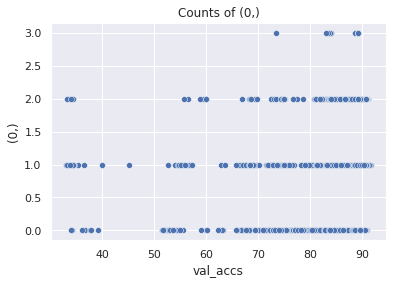

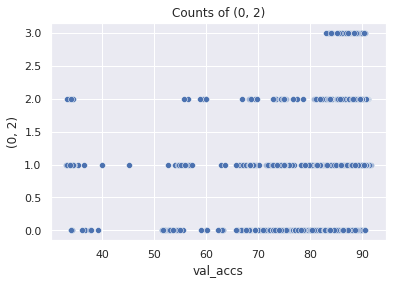

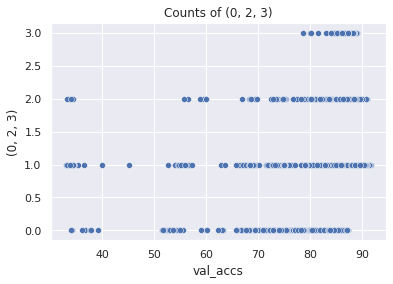

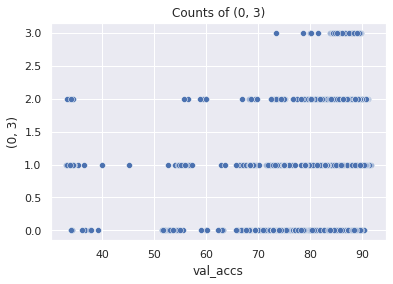

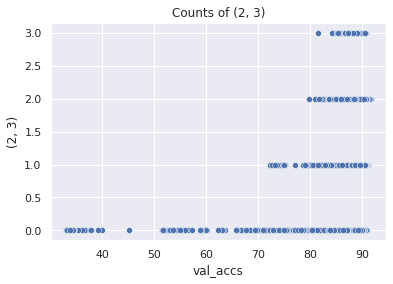

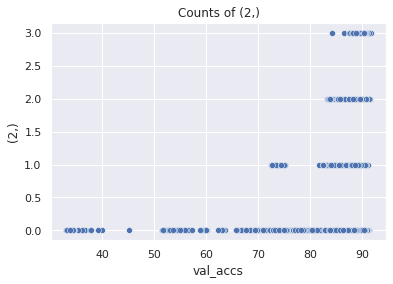

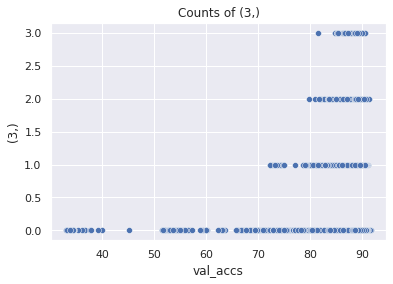

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_df = edge_path_df

import os
#os.mkdir('tmp')

for c in plot_df.columns:
    if c == 'val_accs':
        continue
    plt.figure()
    sns.scatterplot(data=plot_df, x='val_accs', y=c)
    plt.title(f"Counts of {c}")
    #plt.savefig(f'tmp/{c}.png')
    plt.show()

In [483]:
edges = list(edge_map.keys())

dataset_raw = {i: [n[1][e] for e in edges] for i, n in nets.items()}
dataset_raw[0]

[4, 0, 3, 1, 4, 3]

In [520]:
draw = [{'idx': i, **{f'op_{j}': v for j, v in enumerate(o)}} for i, o in dataset_raw.items()]
draw = pd.DataFrame(draw).set_index('idx')

In [521]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)

In [860]:
#dataset = data[[c for c in data.columns if c not in ['random', 'rank', 'new_net', 'net']]]
dataset = pd.concat([draw, opdf, edge_path_df, data[['val_accs', 'params', 'flops']]], axis=1)
y = dataset['val_accs']
#assert all(y.iloc[:, 0] == y.iloc[:, 1])
y = y.iloc[:, 0].copy() if hasattr(y, 'columns') else y
dataset.drop(columns=['val_accs'], inplace=True)

In [861]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(dataset, y, random_state=43, train_size=100)

In [862]:
rf.fit(train_X, train_y)
rf.score(test_X, test_y)

/home/gabi/.env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/gabi/.env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.7842665148480947

In [863]:
preds = rf.predict(dataset)
preds

/home/gabi/.env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([84.2457, 90.1804, 88.7493, ..., 85.4764, 88.4869, 85.6923])

In [864]:
trainpreds = rf.predict(train_X)

/home/gabi/.env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


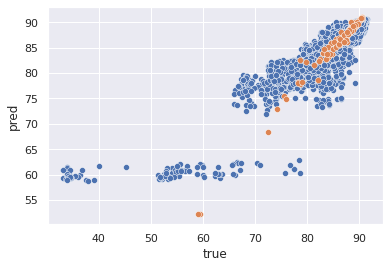

In [865]:
sns.scatterplot(data=pd.DataFrame({'pred': preds, 'true': y}), x='true', y='pred')
sns.scatterplot(data=pd.DataFrame({'pred': trainpreds, 'true': train_y}), x='pred', y='true')
#plt.ylim(70, 95)
plt.show()

In [866]:
from scipy.stats import kendalltau, spearmanr

kendalltau(preds, y)[0], spearmanr(preds, y)[0]

(0.7049389304042775, 0.8778517157578568)

In [757]:
# TODO ruzny pocty siti
# where to sample... important
# TODO predikovat pres proxyny

# ... try that on transnb101